Machine Learning for Churn Prediction
Customer churn is the name for when a subscriber or a regular customer cancels his subscription or stops doing business with a company. Therefore, the churn rate is the measure of how many people stopped being a client of the company ina determined time period.

In business administration, churn is a very important metric of how well the business is doing. If the churn rate is high, then the business is losing a lot of clients and not performing well.

With the evolution of machine learning algorithms and data science, churn prediction has become a very important part of every company's strategy. If a company can accurately predict that a customer is about to churn, it can then act to prevent the churn. Usually working to keep a client is cheaper than working to get a new client.

In this project, we'll work with a churn prediction dataset of a phone/internet company from the IBM Developer platform. The main goal is to build a machine learning model capable of accurately predict that a customer will churn based on the information available in the dataset. In order to accomplish that, we'll go through some main steps, such as:

Exploratory Data Analysis
Data preparation
Train, tune, test, and evaluate machine learning models
Exploratory data analysis
We'll first import everything we'll need and configure the notebook. Then we'll read the data into a DataFrame and display its first five rows.

In [2]:
# Importing
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# Configuring the notebook
%matplotlib inline
sns.set()

# Reading the data
churn = pd.read_csv('/content/CCP.csv')
churn.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


We can see that the first column is an individual key. Also, the majority of the columns contain categorical data.

Let's use the info method to get more information about the data.

In [3]:
churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


From this output we know:

The DataFrame contains 7,043 rows and 21 columns;
There are no missing values;
The TotalCharges column is listed as object but it should be listed as float.
Now, let's see how many unique values each column co

In [4]:
churn.isnull().sum()

,0
customerID,0
gender,0
SeniorCitizen,0
Partner,0
Dependents,0
tenure,0
PhoneService,0
MultipleLines,0
InternetService,0
OnlineSecurity,0


In [5]:
churn.nunique()

,0
customerID,7043
gender,2
SeniorCitizen,2
Partner,2
Dependents,2
tenure,73
PhoneService,2
MultipleLines,3
InternetService,3
OnlineSecurity,3


There are seven columns with only two unique values, including the Churn column, the target variable. We'll call these columns binaries. The other categorical columns contain either three or four unique values.

Data Cleaning

Let's now address the problem in the TotalCharges column. If we ran the code below, and error would be raised informing that some values in this column are filled with whitespaces. Let's then run the next cell and see how many of these values are stored in the column

In [7]:
#churn['TotalCharges'] = pd.to_numeric(churn['TotalCharges'])

In [8]:
nummissing = len(churn[churn['TotalCharges'] == ' '])
print(f'Number of missing values in the TotalCharges column: {nummissing}')

Number of missing values in the TotalCharges column: 11


Eleven rows present this problem. In the next cell we will:

1. Change the whitespaces to null values using np.nan;
2. Convert the column to float;
3. Use the column's median to fill the null values;
4. Check if the values are filled properly and if the values in the column are in the right format.
5. Drop the customerID column.

In [9]:
# Changing the whitespaces to null values using np.nan
churn.loc[churn['TotalCharges'] == ' ', 'TotalCharges'] = np.nan

# Converting the column to float
churn['TotalCharges'] = churn['TotalCharges'].astype(float)

# Using the column's median to fill the null values
churn['TotalCharges'].fillna(churn['TotalCharges'].median(), inplace=True)

# Checking the values and the format
new_missing = len(churn[churn['TotalCharges'] == ' '])
print(f'Number of missing values in the TotalCharges column: {new_missing}')
print(f'Value type: {churn.TotalCharges.dtypes}')

# Dropping the customerID column
churn.drop('customerID', axis=1, inplace=True)

Number of missing values in the TotalCharges column: 0
Value type: float64


/tmp/ipython-input-3943742744.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  churn['TotalCharges'].fillna(churn['TotalCharges'].median(), inplace=True)


In [10]:
#getting the unique values in the column PaymentMethod
churn['PaymentMethod'].value_counts()

,count
PaymentMethod,
Electronic check,2365
Mailed check,1612
Bank transfer (automatic),1544
Credit card (automatic),1522


The PaymentMethod column contains four unique values:

1. Electronic check
2. Mailed check
3. Bank transfer (automatic)
4. Credit card (automatic)
5. We'll remove the string (automatic) from the values only so it's easier to understand the charts we'll plot.

In [11]:
churn['PaymentMethod'] = churn['PaymentMethod'].str.replace('(automatic)', '').str.replace('(', '').str.replace(')', '').str.strip()

In [12]:
churn['PaymentMethod'].value_counts()

,count
PaymentMethod,
Electronic check,2365
Mailed check,1612
Bank transfer,1544
Credit card,1522


## Analysing the Data
We'll now plot a bar chart for each categorical column so we can see how each category in these columns impacts the Churn column.

Before plotting, we'll transform the values in the Churn column from labels Yes and No to numbers 0 and 1. We'll do the opposite with the SeniorCitizen column so the column's chart is properly labeled.

We'll then create three lists:

* One list containing the binary variables, except the Churn;
* One list containing the other categorical variables;
* A third list that will be the addition of the first two.

The third list will be used to plot the charts and the first two we'll be used later on this project to encode the categorical variables.

In [13]:
churn['SeniorCitizen'].value_counts()

,count
SeniorCitizen,
0,5901
1,1142


In [14]:
churn['Churn'].value_counts()

,count
Churn,
No,5174
Yes,1869


In [15]:
# Transforming the values in the Churn and SeniorCitizen columns
churn.loc[churn['Churn'] == 'No','Churn'] = 0
churn.loc[churn['Churn'] == 'Yes','Churn'] = 1
churn['Churn'] = churn['Churn'].astype(int)
churn.loc[churn['SeniorCitizen'] == 0,'SeniorCitizen'] = 'No'
churn.loc[churn['SeniorCitizen'] == 1,'SeniorCitizen'] = 'Yes'

/tmp/ipython-input-2386327477.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'No' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  churn.loc[churn['SeniorCitizen'] == 0,'SeniorCitizen'] = 'No'


In [16]:
# Creating the lists
binary = [col for col in churn.columns if len(churn[col].unique()) == 2 and col != 'Churn']
categorical = [col for col in churn.columns if 2 < len(churn[col].unique()) < 5]
bin_cat = binary + categorical

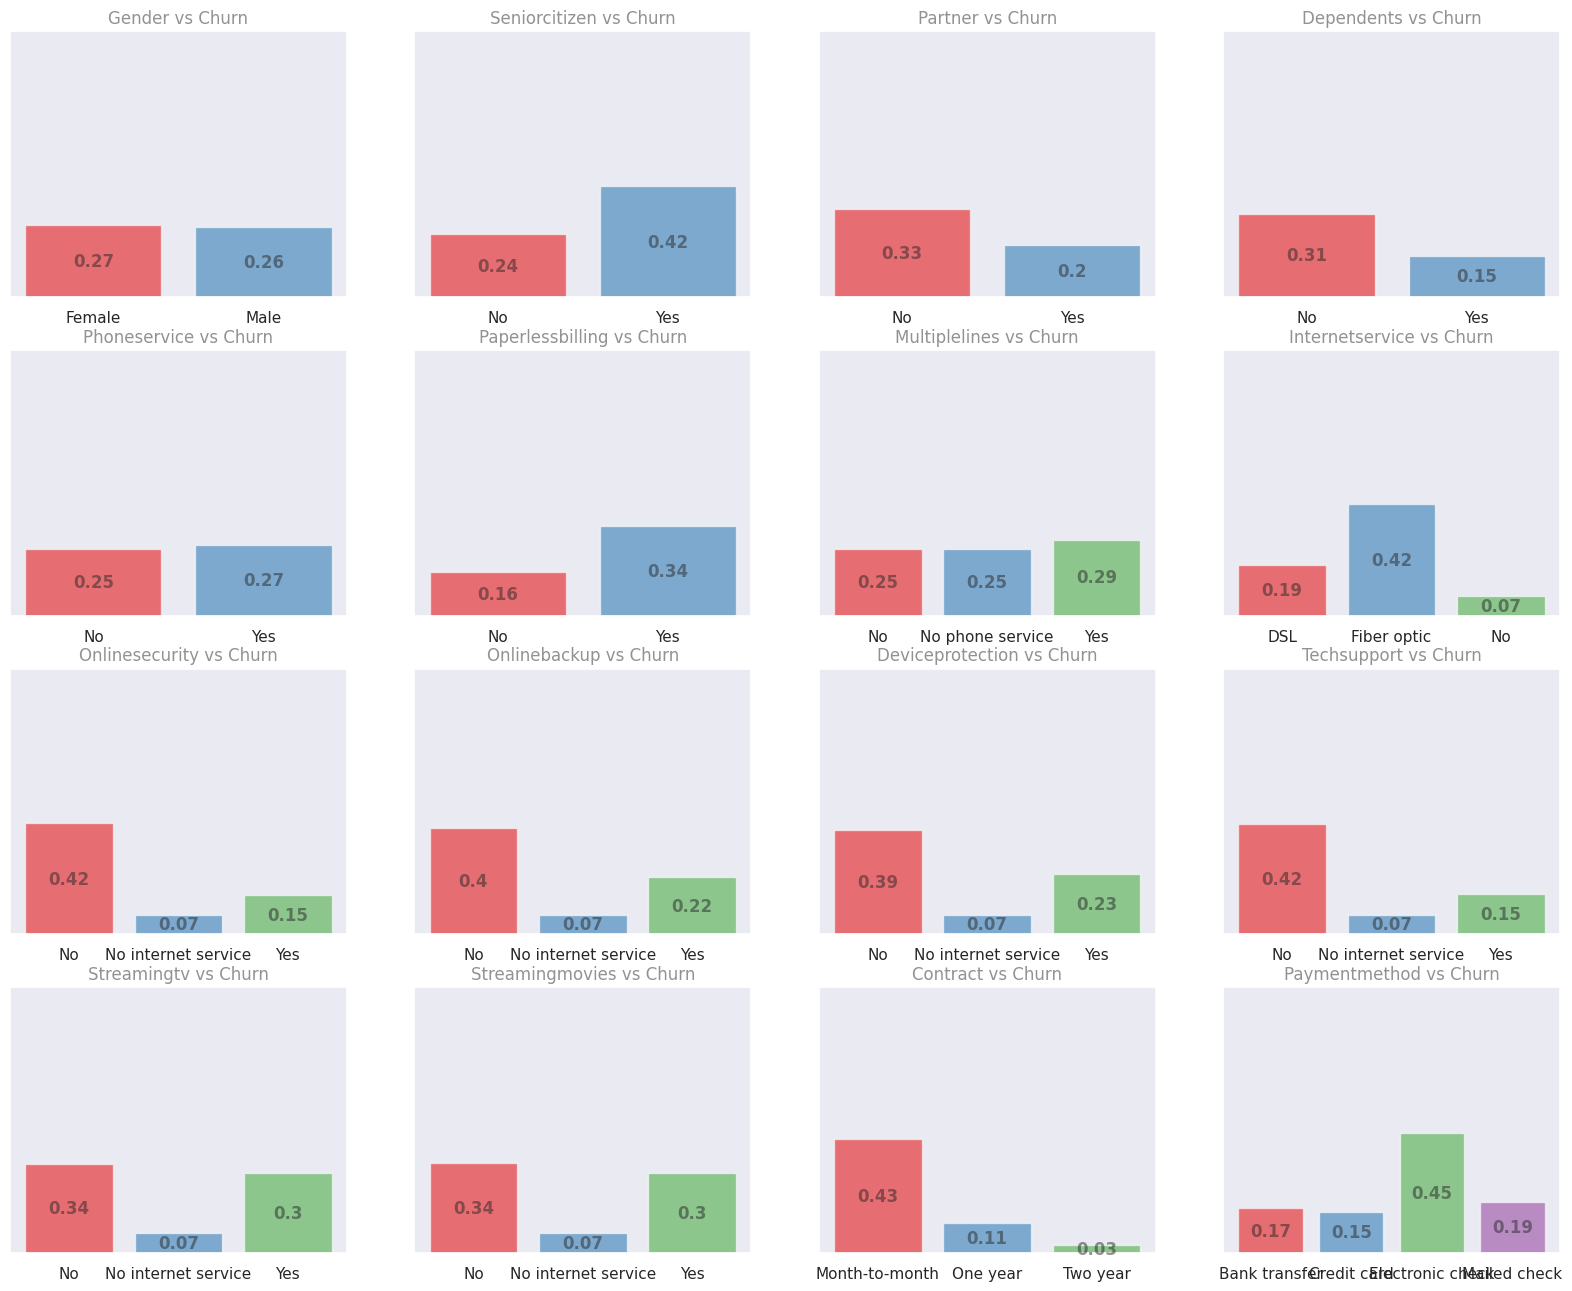

In [17]:
# Plotting
fig = plt.figure(figsize=(20,20))

for i in range(len(bin_cat)):
    churn_plot = churn.groupby(bin_cat[i]).Churn.mean()
    ax = fig.add_subplot(5,4, i+1)
    rects = ax.bar(churn_plot.index, churn_plot, color=sns.color_palette('Set1'), alpha=0.6)
    ax.grid(False)
    ax.set_ylim(0,1)
    ax.tick_params(labelleft=False)
    ax.set_title(f'{bin_cat[i].title()} vs Churn', alpha=0.5)

    for rect in (rects):
        height = rect.get_height()
        ax.text(x=rect.get_x() + rect.get_width() / 2, y=height * 0.5, s=round(height, 2), ha='center', va='center', alpha=0.5, fontweight='bold')


We can learn a lot from these charts. Here are some insights:

* Customers without dependents are two times more likely to churn.
* Customers that use paperless billing and optical fiber are more likely to churn.
* Customers with no online security or backup, no device protection, and no tech support are from two to three times more likely to churn.
* Customers with no internet service are unlikely to churn.
* Customers with month-to-month contracts are almost four times more likely to churn than customers with yearly contracts. Two-year contractors are very unlikely to churn.
* Customers that use electronic checks to pay their bills are more likely to churn.

We'll now use scatter plots to perform the same analysis for the numeric columns.

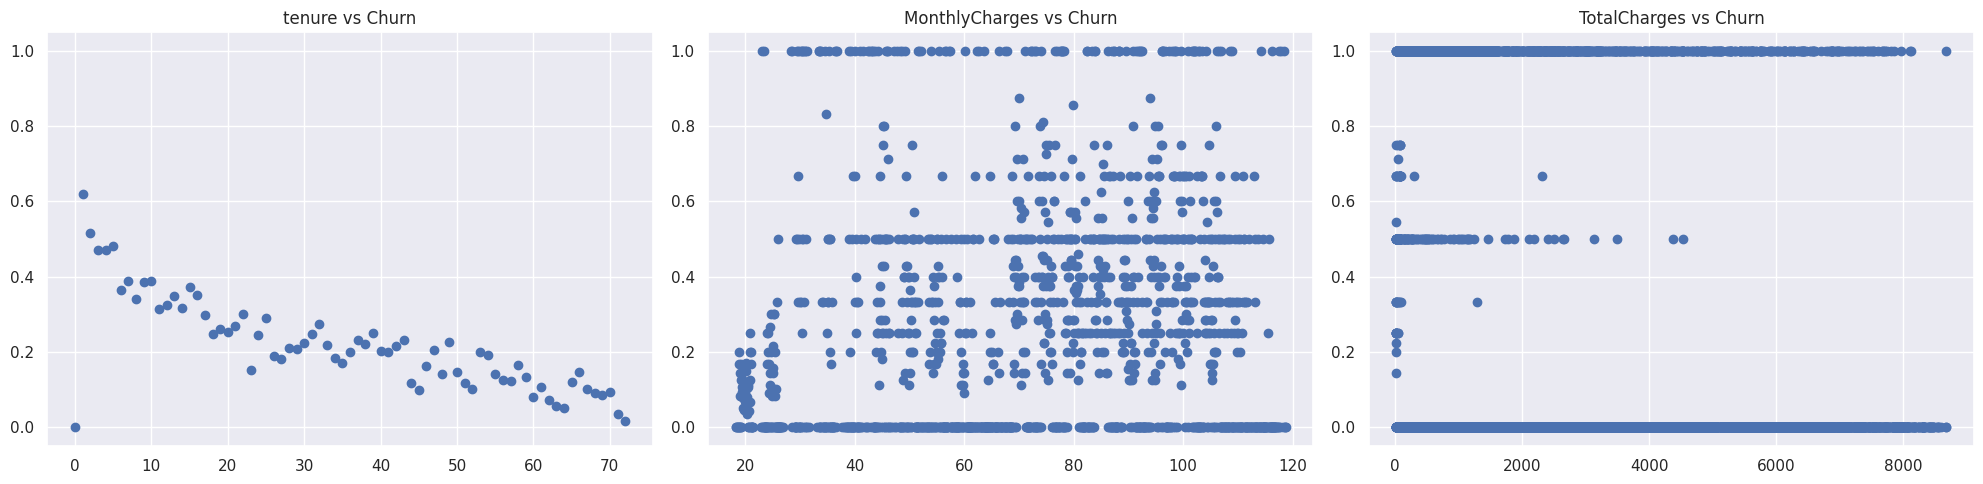

In [18]:
numeric_columns = ['tenure', 'MonthlyCharges', 'TotalCharges']

fig = plt.figure(figsize=(20, 5))

for i in range(len(numeric_columns)):
    num_plot = churn.groupby(numeric_columns[i]).Churn.mean()
    ax = fig.add_subplot(1,3, i+1)
    ax.scatter(num_plot.index, num_plot)
    ax.set_title(f'{numeric_columns[i]} vs Churn')
    ax.set_ylim(-0.05, 1.05)

plt.tight_layout()
plt.show()

We can see there is a significant correlation between the tenure and Churn columns. The highest the tenure, the lowest the chances that the customer will churn.

Unfortunately, there's no much we can say about the MonthlyCharges and TotalCharges columns.

Finally, let's see how balanced the dataset is and decide whether or not to balance it.

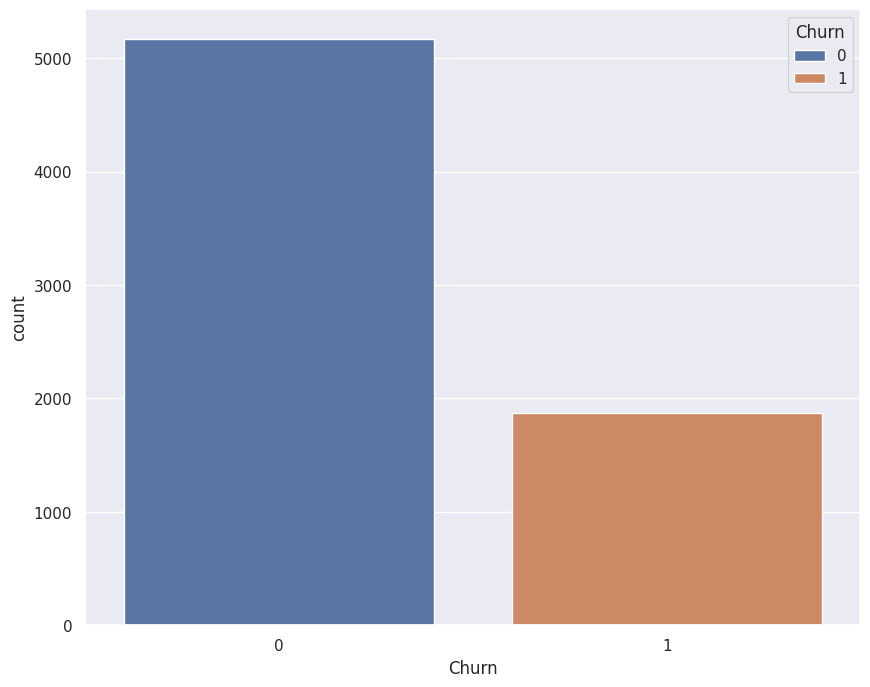

In [19]:
fig, ax = plt.subplots(figsize=(10,8))
sns.countplot(x='Churn', hue='Churn', data=churn)
plt.show()

he dataset is not properly balanced, but it is no highly unbalanced either. Therefore, we'll train machine learning models using unbalanced and balanced data and see which data presents the best results.

### Preparing the Data
We'll now prepare the data to train the models. First, we need to encode the categorical variables. For the binary variables, we'll use the LabelEncoder class and for the other categorical variables we'll use the pandas.get_dummies function.

In [20]:
# Using LabelEncoder on binary columns
for col in binary:
    le = LabelEncoder().fit(churn[col])
    churn[col] = le.transform(churn[col])

In [21]:
# Using get_dummies on categorical columns
churn = pd.get_dummies(churn, columns=categorical)

*Before* training the models, we need to split the data between train and test. In the next cell, we'll also use the RandomUnderSampler class to balance the dataset. We'll then have both balanced and unbalanced training sets.

In [22]:
X = churn.drop('Churn', axis=1)
y = churn['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y)

rus = RandomUnderSampler()

X_rus, y_rus = rus.fit_resample(X_train, y_train)

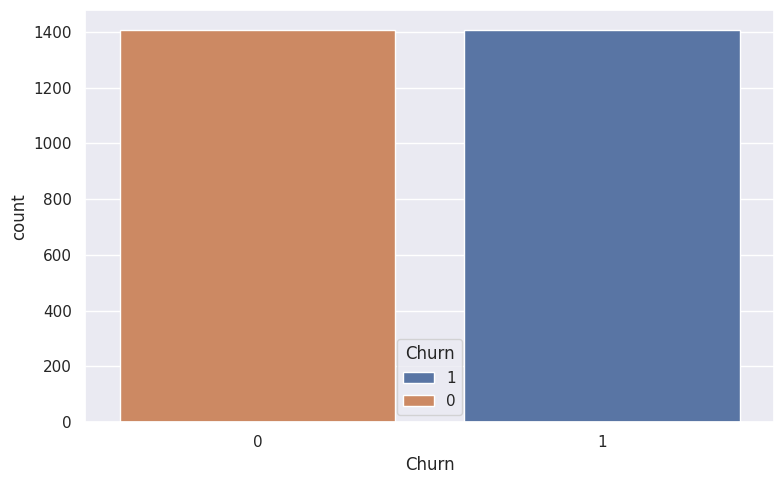

In [23]:
fig, ax = plt.subplots(figsize=(8,5))
sns.countplot(x=pd.Series(y_rus), hue=pd.Series(y_rus), hue_order=[1,0])
plt.tight_layout()
plt.show()


One last step before training the models, we'll standardize the data using the StandardScaler class.

In [24]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
X_rus = scaler.transform(X_rus)

## Models and Metrics
We'll use four different machines learning algorithms:

* Logistic Regression;
* Decision Trees;
* Support Vector Machines - SVM;

Each of the algorithms will be trained using both balanced and unbalanced data so we can see which algorithm-data combination yields the bests results.

### Metrics
The most important metric we'll use is Recall. This metric indicates the proportion of positive results yielded by the model by the total number of positive labels in the dataset. In this case, the Recall reveals the proportion of churns identified correctly by the total number of churns.

Recall is calculated using the following equation:

```
TP/(TP+FN)
```

Where:

* TP: True Positives;
* FN: False Negatives.

We'll also keep track of Precision as a secondary metric. Precision indicates the proportion of positives yielded by the models that are actually true positives.

For the problem we are dealing with, Recall is more important because it's preferable to have a model that does not miss any churns but sometimes classify a non-churns as churns, than a model that does not classify non-churns as churns but misses a lot of churns. In other words, we rather be incorrect when classifying a non-churning costumer than when classifying a churning customer.

We'll now train all the models using cross-validation and store all the results in a DataFrame so we can better visualize them.

In [25]:
#Training the models

logreg_balanced = cross_validate(LogisticRegression(), X_rus, y_rus, cv=5, scoring=['recall', 'precision'])
logreg_unbalanced = cross_validate(LogisticRegression(), X_train, y_train, cv=5, scoring=['recall', 'precision'])

trees_balanced = cross_validate(DecisionTreeClassifier(), X_rus, y_rus, cv=5, scoring=['recall', 'precision'])
trees_unbalanced = cross_validate(DecisionTreeClassifier(), X_train, y_train, cv=5, scoring=['recall', 'precision'])

svm_balanced = cross_validate(SVC(), X_rus, y_rus, cv=5, scoring=['recall', 'precision'])
svm_unbalanced = cross_validate(SVC(), X_train, y_train, cv=5, scoring=['recall', 'precision'])


In [26]:
# Storing the results in a DataFrame
summary = pd.DataFrame({
            'labels': ['recall', 'precision'],
            'logreg_balanced': [logreg_balanced['test_recall'].mean(), logreg_balanced['test_precision'].mean()],
            'logreg_unbalanced': [logreg_unbalanced['test_recall'].mean(), logreg_unbalanced['test_precision'].mean()],
            'trees_balanced': [trees_balanced['test_recall'].mean(), trees_balanced['test_precision'].mean()],
            'trees_unbalanced': [trees_unbalanced['test_recall'].mean(), trees_unbalanced['test_precision'].mean()],
            'svm_balanced': [svm_balanced['test_recall'].mean(), svm_balanced['test_precision'].mean()],
            'svm_unbalanced': [svm_unbalanced['test_recall'].mean(), svm_unbalanced['test_precision'].mean()],
}).set_index('labels')

summary.index.name=None

summary.style.applymap(lambda x: 'background-color: lightgreen' if x >= 0.7 else '')


/tmp/ipython-input-2271616261.py:14: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  summary.style.applymap(lambda x: 'background-color: lightgreen' if x >= 0.7 else '')


,logreg_balanced,logreg_unbalanced,trees_balanced,trees_unbalanced,svm_balanced,svm_unbalanced
recall,0.807539,0.555415,0.668353,0.488693,0.790500,0.502865
precision,0.744643,0.653511,0.675562,0.485954,0.742018,0.645333


### Hyperparameters Tunning
We can see from the DataFrame above that the models that used balanced data yielded better results. So we'll stick with that balanced data.

SVM and Logistic Regression provided similar results in both metrics. Therefore, we'll tune hyperparameters using grid search in all these three models. For that, we'll only considerer Recall for evaluation.

Let's start by tunning the kernel and C in the SVM model.

In [27]:
kfold = StratifiedKFold(n_splits=5, shuffle=True)

svm = SVC()

param_grid = {'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
              'C': [0.001, 0.01, 1, 10, 100]
              }

search = GridSearchCV(svm, param_grid, scoring='recall', cv=kfold)
result = search.fit(X_rus, y_rus)

print(f'Best recall: {result.best_score_} for {result.best_params_}')

Best recall: 0.9353852754852225 for {'C': 0.01, 'kernel': 'poly'}


There was a great improvement in Recall after the SVM model was tuned.

Now let's tune solver and C in the Logistic Regression model.

In [28]:
log_reg = LogisticRegression()

param_grid = {'solver': ['newton-cg', 'lbfgs', 'liblinear'],
              'C': [0.001, 0.01, 1, 10, 100]}

search = GridSearchCV(log_reg, param_grid, scoring='recall', cv=kfold)
result = search.fit(X_rus, y_rus)

print(f'Best recall: {result.best_score_} for {result.best_params_}')

Best recall: 0.8473057217132329 for {'C': 0.001, 'solver': 'liblinear'}


The Logistic Regression model presented a slight improvement after tuned. Not as good as the SVM model, though.
SVM provides the best Recall.
We'll now use the test set to evaluate the SVM model and see if there's any significant difference from the results yielded by the models during training.

              precision    recall  f1-score   support

           0       0.93      0.35      0.51      1300
           1       0.34      0.93      0.49       461

    accuracy                           0.50      1761
   macro avg       0.63      0.64      0.50      1761
weighted avg       0.78      0.50      0.50      1761



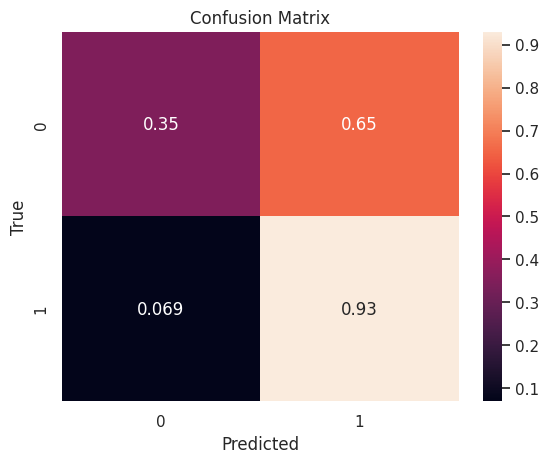

In [29]:
model_svm = SVC(kernel='poly', C=0.01)
model_svm.fit(X_rus, y_rus)
y_pred_svm = model_svm.predict(X_test)

print(classification_report(y_test, y_pred_svm))

fig, ax = plt.subplots()
sns.heatmap(confusion_matrix(y_test, y_pred_svm, normalize='true'), annot=True, ax=ax)
ax.set_title('Confusion Matrix')
ax.set_ylabel('True')
ax.set_xlabel('Predicted')

plt.show()

## Conclusion
In this project, we worked on a churn prediction problem where the main goal was to build a machine learning model capable of correctly identifying the highest possible number of churning customers. For that, we went through the following steps:

* Exploratory data analysis;
* Data cleaning
* Data analysis
* Data preparation
* Training, tunning, and evaluating machine learning models.

As a result, we the SVM model that presented very satisfactory outcomes. We can then consider that objective of the project was accomplished.